In [2]:
# base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Важная настройка для корректной настройки pipeline!
import sklearn

sklearn.set_config(transform_output="default")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    OrdinalEncoder,
    TargetEncoder,
)
from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    cross_val_score,
)

# models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier

from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score


# tunning hyperparamters model
import optuna

## Неделя 2. Вторник 
### Обучение с учителем

### Применение ансаблей моделей для задач классификации и регрессии

1. Загружаем предобработанный датасет (либо загружаем и очищаем, если не осталось сохраненной версии)

In [3]:
df = pd.read_csv("../day01/data/heart.csv")

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40.0,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49.0,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37.0,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48.0,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54.0,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
X, y = df.drop("HeartDisease", axis=1), df["HeartDisease"]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


num = ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"]
cat = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

preprocessor = ColumnTransformer(
    [
        (
            "num",
            Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler()),
                ]
            ),
            num,
        ),
        (
            "cat",
            Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("ohe", OneHotEncoder(handle_unknown="ignore")),
                ]
            ),
            cat,
        ),
    ]
)

2. К прежним датасетам применяем ансамбли моделей: 
    - `RandomForest`
    - `Voting`
    - `Catboost`([https://catboost.ai/en/docs/concepts/python-installation](https://catboost.ai/en/docs/concepts/python-installation))
    - `LightGBM`([https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html](https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html))
    - `XGBoost` ([https://xgboost.readthedocs.io/en/latest/install.html](https://xgboost.readthedocs.io/en/latest/install.html))

## СлучайныйЛес

In [6]:
rf_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "model",
            RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
        ),
    ]
)


rf_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [7]:
print("Train acc:", rf_pipeline.score(X_train, y_train))
print("Valid acc:", rf_pipeline.score(X_valid, y_valid))

Train acc: 0.9904632152588556
Valid acc: 0.9021739130434783


# ❓
Какие значения по умолчанию заданы в случайном лесе для числа деревьев и их глубины?

> ответ тут

Количество деревьев - 100, грубина - без ограничения

# Голосование

In [8]:
logreg = LogisticRegression(max_iter=1000, random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
tree = DecisionTreeClassifier(max_depth=10, random_state=42)

voting_clf = VotingClassifier(
    estimators=[("logreg", logreg), ("knn", knn), ("tree", tree)], voting="soft"
)


voting_pipeline = Pipeline([("preprocessor", preprocessor), ("model", voting_clf)])

voting_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [9]:
print("Train acc:", voting_pipeline.score(X_train, y_train))
print("Valid acc:", voting_pipeline.score(X_valid, y_valid))

Train acc: 0.9618528610354223
Valid acc: 0.8532608695652174


# КотУскорение

In [10]:
cat_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.2,
    depth=3,
    eval_metric="Accuracy",
    verbose=0,
    random_state=42,
)


cat_pipeline = Pipeline([("preprocessor", preprocessor), ("model", cat_model)])


cat_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [11]:
print("Train acc:", cat_pipeline.score(X_train, y_train))
print("Valid acc:", cat_pipeline.score(X_valid, y_valid))

Train acc: 0.952316076294278
Valid acc: 0.875


# СветГБМ

In [12]:
lgbm_model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=3,
    num_leaves=7,
    min_child_samples=40,
    random_state=42,
    verbose=-1,
)

lgbm_pipeline = Pipeline([("preprocessor", preprocessor), ("model", lgbm_model)])

lgbm_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [13]:
print("Train acc:", lgbm_pipeline.score(X_train, y_train))
print("Valid acc:", lgbm_pipeline.score(X_valid, y_valid))

Train acc: 0.9727520435967303
Valid acc: 0.8804347826086957


c:\Users\user\miniforge3\envs\eda_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\user\miniforge3\envs\eda_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# ЭКСГУскорение

In [14]:
xgb_model = XGBClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=3, random_state=42
)

xgb_pipeline = Pipeline([("preprocessor", preprocessor), ("model", xgb_model)])

xgb_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [15]:
print("Train acc:", xgb_pipeline.score(X_train, y_train))
print("Valid acc:", xgb_pipeline.score(X_valid, y_valid))

Train acc: 0.9727520435967303
Valid acc: 0.8858695652173914


3. Прогоните модели через `optuna`, определяем лучшие параметры и сохраняем результат в словарь вида:
    ```python
    results = {'model_name' : best_result}
    ```

Типичные параметры для оптимизации градиентного бустинга: 
* число итераций алгоритма
* глубина деревьев
* скорость обучения (`learning_rate`). 
Чтобы попробовать оптимизировать модели, стоит обратиться к документации: разные реализации будут предлагать разные варианты параметров. 

   > Для классификации используем метрику `accuracy_score`

In [7]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
def objective_rf(trial):
    n_estimators = trial.suggest_int("iterations", 100, 1000)    
    max_depth    = trial.suggest_int("max_depth", 2, 30)        

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42,
        n_jobs=-1
    )

    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
    return float(np.mean(scores))

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=40, n_jobs=-1)

best_rf_params = study_rf.best_params
best_rf_score  = study_rf.best_value
print("RandomForest best:", best_rf_params, "CV acc:", best_rf_score)


[I 2025-08-27 09:21:34,185] A new study created in memory with name: no-name-34328f98-437d-4dd1-bc62-e284b636c4b6
[I 2025-08-27 09:21:39,241] Trial 1 finished with value: 0.8419904948280683 and parameters: {'iterations': 153, 'max_depth': 20}. Best is trial 1 with value: 0.8419904948280683.
[I 2025-08-27 09:21:42,121] Trial 0 finished with value: 0.8515422607399123 and parameters: {'iterations': 461, 'max_depth': 11}. Best is trial 0 with value: 0.8515422607399123.
[I 2025-08-27 09:21:42,930] Trial 7 finished with value: 0.8583543006243595 and parameters: {'iterations': 827, 'max_depth': 14}. Best is trial 7 with value: 0.8583543006243595.
[I 2025-08-27 09:21:43,293] Trial 6 finished with value: 0.8556332121889852 and parameters: {'iterations': 497, 'max_depth': 21}. Best is trial 7 with value: 0.8583543006243595.
[I 2025-08-27 09:21:43,468] Trial 5 finished with value: 0.8501723977262138 and parameters: {'iterations': 264, 'max_depth': 21}. Best is trial 7 with value: 0.85835430062435

RandomForest best: {'iterations': 798, 'max_depth': 3} CV acc: 0.8610753890597334


In [9]:
def objective_cat(trial):
    iterations    = trial.suggest_int("iterations", 200, 1200)      
    max_depth     = trial.suggest_int("max_depth", 3, 8)               
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True) 

    model = CatBoostClassifier(
        iterations=iterations,
        depth=max_depth,
        learning_rate=learning_rate,
        loss_function="Logloss",
        eval_metric="Accuracy",
        verbose=0,
        random_state=42
    )

    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
    return float(np.mean(scores))

study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(objective_cat, n_trials=40, n_jobs=-1)

best_cat_params = study_cat.best_params
best_cat_score  = study_cat.best_value
print("CatBoost best:", best_cat_params, "CV acc:", best_cat_score)


[I 2025-08-27 09:23:49,672] A new study created in memory with name: no-name-343ed256-a232-499d-a45a-f64b26bded37
[I 2025-08-27 09:23:53,137] Trial 2 finished with value: 0.8528189357934954 and parameters: {'iterations': 311, 'max_depth': 4, 'learning_rate': 0.12111638810911222}. Best is trial 2 with value: 0.8528189357934954.
[I 2025-08-27 09:23:55,496] Trial 5 finished with value: 0.8678687913521573 and parameters: {'iterations': 201, 'max_depth': 4, 'learning_rate': 0.03190256955107063}. Best is trial 5 with value: 0.8678687913521573.
[I 2025-08-27 09:23:59,975] Trial 1 finished with value: 0.8610474326716988 and parameters: {'iterations': 273, 'max_depth': 8, 'learning_rate': 0.010550313115099122}. Best is trial 5 with value: 0.8678687913521573.
[I 2025-08-27 09:24:00,252] Trial 3 finished with value: 0.8542074363992171 and parameters: {'iterations': 332, 'max_depth': 6, 'learning_rate': 0.15032229791321847}. Best is trial 5 with value: 0.8678687913521573.
[I 2025-08-27 09:24:01,88

CatBoost best: {'iterations': 529, 'max_depth': 4, 'learning_rate': 0.01682842637432207} CV acc: 0.8719597428012301


In [10]:
def objective_lgbm(trial):
    n_estimators  = trial.suggest_int("iterations", 200, 1200)     
    max_depth     = trial.suggest_int("max_depth", 2, 12)    
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)

    model = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=42
    )

    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
    return float(np.mean(scores))

study_lgbm = optuna.create_study(direction="maximize")
study_lgbm.optimize(objective_lgbm, n_trials=40, n_jobs=-1)

best_lgbm_params = study_lgbm.best_params
best_lgbm_score  = study_lgbm.best_value
print("LightGBM best:", best_lgbm_params, "CV acc:", best_lgbm_score)


[I 2025-08-27 09:25:25,114] A new study created in memory with name: no-name-06ee4e55-e876-40c9-aa68-46c1642c4dda
[I 2025-08-27 09:25:29,027] Trial 0 finished with value: 0.8337619979498649 and parameters: {'iterations': 547, 'max_depth': 9, 'learning_rate': 0.2771082132517632}. Best is trial 0 with value: 0.8337619979498649.
[I 2025-08-27 09:25:30,457] Trial 2 finished with value: 0.8555586618208928 and parameters: {'iterations': 1014, 'max_depth': 3, 'learning_rate': 0.019503957144232784}. Best is trial 2 with value: 0.8555586618208928.
[I 2025-08-27 09:25:33,372] Trial 4 finished with value: 0.8392041748206133 and parameters: {'iterations': 945, 'max_depth': 9, 'learning_rate': 0.10230785249169157}. Best is trial 2 with value: 0.8555586618208928.
[I 2025-08-27 09:25:35,202] Trial 5 finished with value: 0.8351039045755287 and parameters: {'iterations': 505, 'max_depth': 6, 'learning_rate': 0.08828018999518492}. Best is trial 2 with value: 0.8555586618208928.
[I 2025-08-27 09:25:37,29

LightGBM best: {'iterations': 400, 'max_depth': 2, 'learning_rate': 0.016629015109050793} CV acc: 0.8678594725561457


In [11]:
def objective_xgb(trial):
    n_estimators  = trial.suggest_int("iterations", 200, 1200)        
    max_depth     = trial.suggest_int("max_depth", 2, 8)          
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)

    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    )

    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
    return float(np.mean(scores))

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=40, n_jobs=-1)

best_xgb_params = study_xgb.best_params
best_xgb_score  = study_xgb.best_value
print("XGBoost best:", best_xgb_params, "CV acc:", best_xgb_score)

[I 2025-08-27 09:26:58,941] A new study created in memory with name: no-name-ef8ad4be-b423-4f2f-9175-0e566407bea9
[I 2025-08-27 09:26:59,871] Trial 1 finished with value: 0.8528655297735532 and parameters: {'iterations': 249, 'max_depth': 5, 'learning_rate': 0.08923469821025305}. Best is trial 1 with value: 0.8528655297735532.
[I 2025-08-27 09:26:59,967] Trial 0 finished with value: 0.8378343118069145 and parameters: {'iterations': 488, 'max_depth': 8, 'learning_rate': 0.14960573541666425}. Best is trial 1 with value: 0.8528655297735532.
[I 2025-08-27 09:27:01,038] Trial 2 finished with value: 0.8542167551952288 and parameters: {'iterations': 724, 'max_depth': 3, 'learning_rate': 0.029506294068844727}. Best is trial 2 with value: 0.8542167551952288.
[I 2025-08-27 09:27:01,040] Trial 4 finished with value: 0.8460162147050602 and parameters: {'iterations': 818, 'max_depth': 5, 'learning_rate': 0.22144820663748307}. Best is trial 2 with value: 0.8542167551952288.
[I 2025-08-27 09:27:01,17

XGBoost best: {'iterations': 372, 'max_depth': 2, 'learning_rate': 0.01732552918393789} CV acc: 0.8665175659304818


In [16]:
# === 1) Импорты ===
import optuna
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Базовые модели
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Бустинги
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# === 2) CV-схема для честной оценки ===
cv = KFold(n_splits=5, shuffle=True, random_state=42)


# === 3) Общая objective-функция для всех 5 моделей ===
def objective(trial):
    # 3.1 Выбираем модель как гиперпараметр
    model_name = trial.suggest_categorical(
        "model", ["rf", "cat", "lgbm", "xgb", "voting"]
    )

    # 3.2 Условно задаём пространство гиперпараметров
    if model_name == "rf":
        # RandomForest: число деревьев, глубина, размер листа, стратегия подвыбора признаков
        n_estimators = trial.suggest_int("rf_n_estimators", 100, 800)
        max_depth = trial.suggest_int("rf_max_depth", 2, 20)
        min_samples_leaf = trial.suggest_int("rf_min_samples_leaf", 1, 10)
        max_features = trial.suggest_categorical("rf_max_features", ["sqrt", "log2"])
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=42,
            n_jobs=-1,
        )

    elif model_name == "cat":
        # CatBoost: итерации, глубина, lr, L2; выключаем болтливость
        iterations = trial.suggest_int("cat_iterations", 200, 1000)
        depth = trial.suggest_int("cat_depth", 3, 8)
        learning_rate = trial.suggest_float("cat_learning_rate", 0.01, 0.3, log=True)
        l2_leaf_reg = trial.suggest_float("cat_l2_leaf_reg", 1.0, 10.0)
        model = CatBoostClassifier(
            iterations=iterations,
            depth=depth,
            learning_rate=learning_rate,
            l2_leaf_reg=l2_leaf_reg,
            eval_metric="Accuracy",
            verbose=0,
            random_state=42,
        )

    elif model_name == "lgbm":
        # LightGBM: итерации, глубина, lr, листья, min_child_samples, L2
        n_estimators = trial.suggest_int("lgbm_n_estimators", 200, 1000)
        max_depth = trial.suggest_int("lgbm_max_depth", 2, 12)
        learning_rate = trial.suggest_float("lgbm_learning_rate", 0.01, 0.3, log=True)
        num_leaves = trial.suggest_int("lgbm_num_leaves", 7, 63)
        min_child_samples = trial.suggest_int("lgbm_min_child_samples", 5, 50)
        reg_lambda = trial.suggest_float("lgbm_reg_lambda", 0.0, 5.0)
        model = LGBMClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_samples=min_child_samples,
            reg_lambda=reg_lambda,
            random_state=42,
        )

    elif model_name == "xgb":
        # XGBoost: итерации, глубина, lr; плюс subsample/colsample для регуляризации
        n_estimators = trial.suggest_int("xgb_n_estimators", 200, 1000)
        max_depth = trial.suggest_int("xgb_max_depth", 2, 8)
        learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.3, log=True)
        subsample = trial.suggest_float("xgb_subsample", 0.6, 1.0)
        colsample = trial.suggest_float("xgb_colsample_bytree", 0.6, 1.0)
        model = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample,
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1,
        )

    else:  # model_name == "voting"
        # Voting: фиксируем состав простых базовых моделей и подберём веса
        # Все 3 умеют predict_proba → можем использовать мягкое голосование
        logreg = LogisticRegression(max_iter=1000, random_state=42)
        knn = KNeighborsClassifier(
            n_neighbors=trial.suggest_int("knn_n_neighbors", 3, 15)
        )
        tree = DecisionTreeClassifier(
            max_depth=trial.suggest_int("tree_max_depth", 2, 10), random_state=42
        )
        # Веса голосования — свободные положительные числа; нормализуем внутри Voting
        w1 = trial.suggest_float("w_logreg", 0.1, 3.0, log=True)
        w2 = trial.suggest_float("w_knn", 0.1, 3.0, log=True)
        w3 = trial.suggest_float("w_tree", 0.1, 3.0, log=True)

        model = VotingClassifier(
            estimators=[("logreg", logreg), ("knn", knn), ("tree", tree)],
            voting="soft",
            weights=[w1, w2, w3],
            n_jobs=-1,
        )

    # 3.3 Пайплайн: наш общий препроцессор + выбранная модель
    pipeline = Pipeline([("preprocessor", preprocessor), ("model", model)])

    # 3.4 5-fold CV по accuracy; берём среднее — это и есть целевая метрика
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    mean_score = float(np.mean(scores))

    # 3.5 Сохраним, какая модель была в этом trial — пригодится для пост-анализа
    trial.set_user_attr("which_model", model_name)
    return mean_score


# === 4) Запуск одного общего исследования ===
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, n_jobs=-1)  # можно увеличить n_trials

print("Глобально лучший trial:")
print("  value:", study.best_value)
print("  params:", study.best_params)

# === 5) Достаём ЛУЧШИЙ trial для КАЖДОЙ модели отдельно ===
best_by_model = {}
for t in study.trials:
    if t.state != optuna.trial.TrialState.COMPLETE:
        continue
    m = t.user_attrs.get("which_model")
    if m is None:
        continue
    if (m not in best_by_model) or (t.value > best_by_model[m].value):
        best_by_model[m] = t

# Человекочитаемые имена и словарь результатов по условию
name_map = {
    "rf": "RandomForest",
    "cat": "CatBoost",
    "lgbm": "LightGBM",
    "xgb": "XGBoost",
    "voting": "Voting",
}

results = {name_map[k]: best_by_model[k].value for k in best_by_model.keys()}
results_df = pd.DataFrame.from_dict(
    results, orient="index", columns=["best_cv_accuracy"]
).sort_values("best_cv_accuracy", ascending=False)

print("\nЛучшие CV-accuracy по каждой модели:")
print(results_df)

print("\nЛучшие параметры по каждой модели:")
for k, trial in best_by_model.items():
    print(f"\n[{name_map[k]}] score={trial.value:.4f}")
    for p, v in trial.params.items():
        print(f"  {p} = {v}")

[I 2025-08-26 17:47:03,928] A new study created in memory with name: no-name-4ed86d4d-46e2-4a7b-8c09-7c19f7504983


[I 2025-08-26 17:47:08,986] Trial 0 finished with value: 0.8768650510810169 and parameters: {'model': 'cat', 'cat_iterations': 354, 'cat_depth': 5, 'cat_learning_rate': 0.08506611769071257, 'cat_l2_leaf_reg': 1.5848650974500758}. Best is trial 0 with value: 0.8768650510810169.
[I 2025-08-26 17:47:10,144] Trial 1 finished with value: 0.8714065098598243 and parameters: {'model': 'lgbm', 'lgbm_n_estimators': 304, 'lgbm_max_depth': 2, 'lgbm_learning_rate': 0.07219743124806031, 'lgbm_num_leaves': 57, 'lgbm_min_child_samples': 26, 'lgbm_reg_lambda': 2.012876930885672}. Best is trial 0 with value: 0.8768650510810169.
[I 2025-08-26 17:47:10,865] Trial 2 finished with value: 0.8714124495129484 and parameters: {'model': 'voting', 'knn_n_neighbors': 7, 'tree_max_depth': 4, 'w_logreg': 0.994004349789051, 'w_knn': 0.710468127569198, 'w_tree': 0.19117422843592807}. Best is trial 0 with value: 0.8768650510810169.
[I 2025-08-26 17:47:11,682] Trial 6 finished with value: 0.870319553338085 and parameter

Глобально лучший trial:
  value: 0.8844975053456878
  params: {'model': 'cat', 'cat_iterations': 682, 'cat_depth': 7, 'cat_learning_rate': 0.024961996145737936, 'cat_l2_leaf_reg': 3.919196646579688}

Лучшие CV-accuracy по каждой модели:
              best_cv_accuracy
CatBoost              0.884498
XGBoost               0.876865
RandomForest          0.875772
Voting                0.871412
LightGBM              0.871407

Лучшие параметры по каждой модели:

[CatBoost] score=0.8845
  model = cat
  cat_iterations = 682
  cat_depth = 7
  cat_learning_rate = 0.024961996145737936
  cat_l2_leaf_reg = 3.919196646579688

[LightGBM] score=0.8714
  model = lgbm
  lgbm_n_estimators = 304
  lgbm_max_depth = 2
  lgbm_learning_rate = 0.07219743124806031
  lgbm_num_leaves = 57
  lgbm_min_child_samples = 26
  lgbm_reg_lambda = 2.012876930885672

[Voting] score=0.8714
  model = voting
  knn_n_neighbors = 7
  tree_max_depth = 4
  w_logreg = 0.994004349789051
  w_knn = 0.710468127569198
  w_tree = 0.191174

4. Превращаем словарь в `DataFrame` и сравниваем полученные результаты. Строим `bar_plot` для визуализации метрики качества. 

In [17]:
# ===========================================
# 0) Импорты
# ===========================================
import numpy as np
import pandas as pd
import optuna

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

# Бэйслайны / ансамбли
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Бустинги
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# ===========================================
# 1) CV-схема (5 фолдов × 3 повторения)
# ===========================================
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)


# ===========================================
# 2) Единая objective-функция для 5 моделей
#    (модель выбирается как гиперпараметр)
#    ВНИМАНИЕ: используем ТОЛЬКО train в CV!
# ===========================================
def objective(trial):
    model_name = trial.suggest_categorical(
        "model", ["rf", "cat", "lgbm", "xgb", "voting"]
    )

    if model_name == "rf":
        params = dict(
            n_estimators=trial.suggest_int("rf_n_estimators", 100, 1000),
            max_depth=trial.suggest_int("rf_max_depth", 2, 20),
            min_samples_leaf=trial.suggest_int("rf_min_samples_leaf", 1, 20),
            max_features=trial.suggest_categorical("rf_max_features", ["sqrt", "log2"]),
            random_state=42,
            n_jobs=-1,
        )
        model = RandomForestClassifier(**params)

    elif model_name == "cat":
        params = dict(
            iterations=trial.suggest_int("cat_iterations", 200, 1000),
            depth=trial.suggest_int("cat_depth", 3, 8),
            learning_rate=trial.suggest_float("cat_learning_rate", 0.01, 0.3, log=True),
            l2_leaf_reg=trial.suggest_float("cat_l2_leaf_reg", 1.0, 10.0),
            subsample=trial.suggest_float("cat_subsample", 0.6, 1.0),
            random_state=42,
            loss_function="Logloss",
            eval_metric="Accuracy",
            verbose=0,
        )
        model = CatBoostClassifier(**params)

    elif model_name == "lgbm":
        params = dict(
            n_estimators=trial.suggest_int("lgbm_n_estimators", 200, 1200),
            max_depth=trial.suggest_int("lgbm_max_depth", 2, 12),
            learning_rate=trial.suggest_float(
                "lgbm_learning_rate", 0.01, 0.3, log=True
            ),
            num_leaves=trial.suggest_int("lgbm_num_leaves", 7, 63),
            min_child_samples=trial.suggest_int("lgbm_min_child_samples", 5, 60),
            subsample=trial.suggest_float("lgbm_subsample", 0.6, 1.0),
            colsample_bytree=trial.suggest_float("lgbm_colsample_bytree", 0.6, 1.0),
            reg_lambda=trial.suggest_float("lgbm_reg_lambda", 0.0, 5.0),
            reg_alpha=trial.suggest_float("lgbm_reg_alpha", 0.0, 2.0),
            random_state=42,
        )
        model = LGBMClassifier(**params)

    elif model_name == "xgb":
        params = dict(
            n_estimators=trial.suggest_int("xgb_n_estimators", 200, 1200),
            max_depth=trial.suggest_int("xgb_max_depth", 2, 8),
            learning_rate=trial.suggest_float("xgb_learning_rate", 0.01, 0.3, log=True),
            subsample=trial.suggest_float("xgb_subsample", 0.6, 1.0),
            colsample_bytree=trial.suggest_float("xgb_colsample_bytree", 0.6, 1.0),
            min_child_weight=trial.suggest_float("xgb_min_child_weight", 1.0, 10.0),
            reg_lambda=trial.suggest_float("xgb_reg_lambda", 0.0, 5.0),
            reg_alpha=trial.suggest_float("xgb_reg_alpha", 0.0, 2.0),
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1,
        )
        model = XGBClassifier(**params)

    else:  # voting
        # фиксируем состав простых базовых: логрег + knn + дерево
        logreg = LogisticRegression(max_iter=1000, random_state=42)
        knn = KNeighborsClassifier(
            n_neighbors=trial.suggest_int("knn_n_neighbors", 3, 21, step=2)
        )
        tree = DecisionTreeClassifier(
            max_depth=trial.suggest_int("tree_max_depth", 2, 12), random_state=42
        )
        w1 = trial.suggest_float("w_logreg", 0.1, 3.0, log=True)
        w2 = trial.suggest_float("w_knn", 0.1, 3.0, log=True)
        w3 = trial.suggest_float("w_tree", 0.1, 3.0, log=True)
        model = VotingClassifier(
            estimators=[("logreg", logreg), ("knn", knn), ("tree", tree)],
            voting="soft",
            weights=[w1, w2, w3],
            n_jobs=-1,
        )

    # Пайплайн: препроцессор -> модель
    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])

    # CV только на TRAIN (никаких утечек на hold-out)
    scores = cross_val_score(
        pipe, X_train, y_train, cv=rskf, scoring="accuracy", n_jobs=-1
    )
    trial.set_user_attr("which_model", model_name)
    return float(scores.mean())


# ===========================================
# 3) Запуск общего поиска
# ===========================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=80, n_jobs=-1)  # при желании увеличь n_trials

print("Глобально лучший trial:")
print("  value :", study.best_value)
print("  params:", study.best_params)

# ===========================================
# 4) Достаём ЛУЧШИЙ trial для КАЖДОЙ модели
# ===========================================
best_by_model = {}
for t in study.trials:
    if t.state.name != "COMPLETE":
        continue
    m = t.user_attrs.get("which_model")
    if m is None:
        continue
    if (m not in best_by_model) or (t.value > best_by_model[m].value):
        best_by_model[m] = t

name_map = {
    "rf": "RandomForest",
    "cat": "CatBoost",
    "lgbm": "LightGBM",
    "xgb": "XGBoost",
    "voting": "Voting",
}

# ===========================================
# 5) Для каждой лучшей модели:
#    - пересобираем пайплайн с её лучшими params
#    - считаем Repeated CV mean±std на TRAIN
#    - обучаем на TRAIN и меряем hold-out (X_valid)
# ===========================================
rows = []
for key, trial in best_by_model.items():
    model_name = name_map[key]
    p = trial.params.copy()
    # восстанавливаем модель из параметров trial:
    if key == "rf":
        model = RandomForestClassifier(
            n_estimators=p["rf_n_estimators"],
            max_depth=p["rf_max_depth"],
            min_samples_leaf=p["rf_min_samples_leaf"],
            max_features=p["rf_max_features"],
            random_state=42,
            n_jobs=-1,
        )
    elif key == "cat":
        model = CatBoostClassifier(
            iterations=p["cat_iterations"],
            depth=p["cat_depth"],
            learning_rate=p["cat_learning_rate"],
            l2_leaf_reg=p["cat_l2_leaf_reg"],
            subsample=p["cat_subsample"],
            loss_function="Logloss",
            eval_metric="Accuracy",
            verbose=0,
            random_state=42,
        )
    elif key == "lgbm":
        model = LGBMClassifier(
            n_estimators=p["lgbm_n_estimators"],
            max_depth=p["lgbm_max_depth"],
            learning_rate=p["lgbm_learning_rate"],
            num_leaves=p["lgbm_num_leaves"],
            min_child_samples=p["lgbm_min_child_samples"],
            subsample=p["lgbm_subsample"],
            colsample_bytree=p["lgbm_colsample_bytree"],
            reg_lambda=p["lgbm_reg_lambda"],
            reg_alpha=p["lgbm_reg_alpha"],
            random_state=42,
        )
    elif key == "xgb":
        model = XGBClassifier(
            n_estimators=p["xgb_n_estimators"],
            max_depth=p["xgb_max_depth"],
            learning_rate=p["xgb_learning_rate"],
            subsample=p["xgb_subsample"],
            colsample_bytree=p["xgb_colsample_bytree"],
            min_child_weight=p["xgb_min_child_weight"],
            reg_lambda=p["xgb_reg_lambda"],
            reg_alpha=p["xgb_reg_alpha"],
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1,
        )
    else:  # voting
        logreg = LogisticRegression(max_iter=1000, random_state=42)
        knn = KNeighborsClassifier(n_neighbors=p["knn_n_neighbors"])
        tree = DecisionTreeClassifier(max_depth=p["tree_max_depth"], random_state=42)
        model = VotingClassifier(
            estimators=[("logreg", logreg), ("knn", knn), ("tree", tree)],
            voting="soft",
            weights=[p["w_logreg"], p["w_knn"], p["w_tree"]],
            n_jobs=-1,
        )

    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])
    # CV (mean±std) на TRAIN
    cv_scores = cross_val_score(
        pipe, X_train, y_train, cv=rskf, scoring="accuracy", n_jobs=-1
    )
    cv_mean, cv_std = float(cv_scores.mean()), float(cv_scores.std())

    # Hold-out: обучаем на TRAIN, меряем на VALID
    pipe.fit(X_train, y_train)
    valid_acc = float(pipe.score(X_valid, y_valid))

    rows.append([model_name, cv_mean, cv_std, valid_acc, trial.value])

# Итоговая таблица
results_df = pd.DataFrame(
    rows, columns=["model", "cv_mean", "cv_std", "valid_acc", "best_trial_cv"]
)
results_df = results_df.sort_values("valid_acc", ascending=False).set_index("model")
results = {
    idx: results_df.loc[idx, "best_trial_cv"] for idx in results_df.index
}  # как просили: {'model_name': best_result}

print("\n=== Итоги (Repeated 5x3 CV и hold-out на X_valid) ===")
print(results_df)
print("\nresults =", results)

[I 2025-08-26 17:47:44,761] A new study created in memory with name: no-name-56c89a96-e3c9-4c9c-91a7-591fec13301d
[I 2025-08-26 17:47:58,184] Trial 0 finished with value: 0.8524120150343244 and parameters: {'model': 'cat', 'cat_iterations': 892, 'cat_depth': 4, 'cat_learning_rate': 0.09653841078109773, 'cat_l2_leaf_reg': 2.462552516959228, 'cat_subsample': 0.6203225274651427}. Best is trial 0 with value: 0.8524120150343244.
[I 2025-08-26 17:48:03,550] Trial 3 finished with value: 0.862861491628615 and parameters: {'model': 'lgbm', 'lgbm_n_estimators': 712, 'lgbm_max_depth': 3, 'lgbm_learning_rate': 0.014125171660687606, 'lgbm_num_leaves': 24, 'lgbm_min_child_samples': 40, 'lgbm_subsample': 0.7793545151361234, 'lgbm_colsample_bytree': 0.9171332899972177, 'lgbm_reg_lambda': 1.8936112895432462, 'lgbm_reg_alpha': 0.14256896420553522}. Best is trial 3 with value: 0.862861491628615.
[I 2025-08-26 17:48:07,271] Trial 4 finished with value: 0.8623831267666883 and parameters: {'model': 'rf', 'r

Глобально лучший trial:
  value : 0.8719379989438697
  params: {'model': 'xgb', 'xgb_n_estimators': 222, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.020913213279190067, 'xgb_subsample': 0.7814051510680114, 'xgb_colsample_bytree': 0.6060479947344803, 'xgb_min_child_weight': 4.276420028515244, 'xgb_reg_lambda': 1.6333258916233042, 'xgb_reg_alpha': 0.10214303315466211}


c:\Users\user\miniforge3\envs\eda_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:50:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\miniforge3\envs\eda_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Итоги (Repeated 5x3 CV и hold-out на X_valid) ===
               cv_mean    cv_std  valid_acc  best_trial_cv
model                                                     
XGBoost       0.871938  0.027219   0.907609       0.871938
RandomForest  0.863318  0.032770   0.896739       0.863318
Voting        0.859236  0.028754   0.896739       0.859236
CatBoost      0.870124  0.029014   0.891304       0.870124
LightGBM      0.867841  0.023184   0.880435       0.867841

results = {'XGBoost': np.float64(0.8719379989438697), 'RandomForest': np.float64(0.863318112633181), 'Voting': np.float64(0.85923647998012), 'CatBoost': np.float64(0.8701239399869538), 'LightGBM': np.float64(0.8678408349641227)}


                 score
XGBoost       0.871938
CatBoost      0.870124
LightGBM      0.867841
RandomForest  0.863318
Voting        0.859236


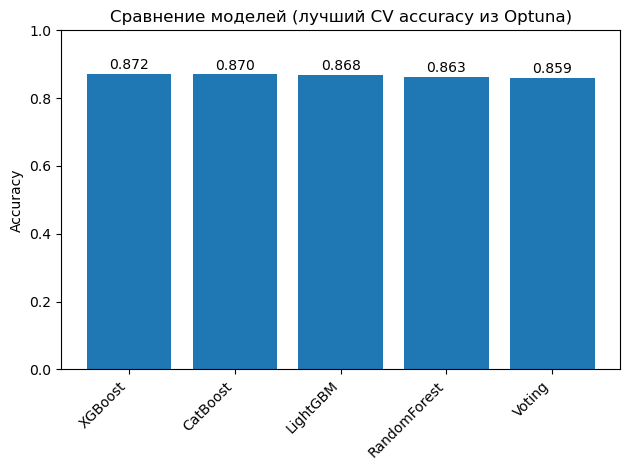

In [18]:
df_scores = (
    pd.Series(results, name="score").to_frame().sort_values("score", ascending=False)
)

print(df_scores)

plt.figure()
plt.bar(df_scores.index, df_scores["score"].values)
plt.title("Сравнение моделей (лучший CV accuracy из Optuna)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()


for i, v in enumerate(df_scores["score"].values):
    plt.text(i, v + 0.005, f"{v:.3f}", ha="center", va="bottom", rotation=0)
plt.show()

5. Выберете лучшую модель и попробуйте задеплоить ее в Streamlit.

* Создайте просто интерфейс для пользователя, куда бы он мог ввести необходимые данные, а вы бы ему вернули предсказание

In [ ]:
# берём лучший trial для выбранной модели
best_trial = best_by_model["lgbm"]   # например, если выбрали LightGBM

# достаём его параметры
best_params = best_trial.params
print(best_params)

# восстанавливаем модель
best_model = LGBMClassifier(
    n_estimators=best_params["lgbm_n_estimators"],
    max_depth=best_params["lgbm_max_depth"],
    learning_rate=best_params["lgbm_learning_rate"],
    num_leaves=best_params["lgbm_num_leaves"],
    min_child_samples=best_params["lgbm_min_child_samples"],
    subsample=best_params["lgbm_subsample"],
    colsample_bytree=best_params["lgbm_colsample_bytree"],
    reg_lambda=best_params["lgbm_reg_lambda"],
    reg_alpha=best_params["lgbm_reg_alpha"],
    random_state=42
)

# собираем финальный пайплайн
final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", best_model)
])

# дообучаем на ВСЁМ train
final_pipeline.fit(X_train, y_train)

# проверяем на valid
print("Final valid acc:", final_pipeline.score(X_valid, y_valid))


{'model': 'lgbm', 'lgbm_n_estimators': 220, 'lgbm_max_depth': 12, 'lgbm_learning_rate': 0.22535654085165466, 'lgbm_num_leaves': 52, 'lgbm_min_child_samples': 7, 'lgbm_subsample': 0.615857455251317, 'lgbm_colsample_bytree': 0.6369422172814639, 'lgbm_reg_lambda': 0.14461256238225895, 'lgbm_reg_alpha': 1.636234409771121}
Final valid acc: 0.8804347826086957


c:\Users\user\miniforge3\envs\eda_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [20]:
import joblib

joblib.dump(final_pipeline, "best_pipeline.pkl")

['best_pipeline.pkl']

In [ ]:
def objective_cat(trial):
    iterations = trial.suggest_int("iterations", 200, 1200)
    depth = trial.suggest_int("depth", 3, 8)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)

    cat = CatBoostClassifier(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        loss_function="Logloss",
        eval_metric="Accuracy",
        verbose=0,
        random_state=42,
    )

    pipe = Pipeline([("preprocessor", preprocessor), ("model", cat)])

    scores = cross_val_score(
        pipe, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1
    )
    return float(scores.mean())

study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(objective_cat, n_trials=40, n_jobs=-1)

print("Лучший CV-accuracy (CatBoost):", study_cat.best_value)
print("Лучшие параметры (CatBoost):", study_cat.best_params)

[I 2025-08-26 17:50:08,526] A new study created in memory with name: no-name-ada362a2-84d3-4809-be30-1d62f8e34327
[I 2025-08-26 17:50:18,206] Trial 1 finished with value: 0.8637405647190383 and parameters: {'iterations': 1096, 'depth': 6, 'learning_rate': 0.014802563336695862}. Best is trial 1 with value: 0.8637405647190383.
[I 2025-08-26 17:50:18,741] Trial 4 finished with value: 0.8692200167738328 and parameters: {'iterations': 321, 'depth': 4, 'learning_rate': 0.03285224030414169}. Best is trial 4 with value: 0.8692200167738328.
[I 2025-08-26 17:50:22,362] Trial 11 finished with value: 0.8596496132699656 and parameters: {'iterations': 257, 'depth': 7, 'learning_rate': 0.05482503876586856}. Best is trial 4 with value: 0.8692200167738328.
[I 2025-08-26 17:50:28,934] Trial 10 finished with value: 0.8487559407324573 and parameters: {'iterations': 754, 'depth': 6, 'learning_rate': 0.1071577569430994}. Best is trial 4 with value: 0.8692200167738328.
[I 2025-08-26 17:50:30,077] Trial 3 fin

Лучший CV-accuracy (CatBoost): 0.8718945112291492
Лучшие параметры (CatBoost): {'iterations': 555, 'depth': 5, 'learning_rate': 0.01791394023086274}


In [ ]:

best_p = study_cat.best_params

best_cat = CatBoostClassifier(
    iterations=best_p["iterations"],
    depth=best_p["depth"],
    learning_rate=best_p["learning_rate"],
    loss_function="Logloss",
    eval_metric="Accuracy",
    verbose=0,
    random_state=42,
)

cat_pipeline = Pipeline([("preprocessor", preprocessor), ("model", best_cat)])

cat_pipeline.fit(X_train, y_train)
valid_acc = cat_pipeline.score(X_valid, y_valid)
print("Hold-out (X_valid) accuracy для лучшего CatBoost:", valid_acc)

Hold-out (X_valid) accuracy для лучшего CatBoost: 0.9021739130434783
